In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image, channels = 3)
  return image

def resize(input_image, height, width):
  return tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

def random_crop(input_image, height, width):
  return tf.image.random_crop(input_image, size=[height, width, 3])

# Normalizing the images to [-1, 1]
def normalize(input_image):
  input_image = tf.cast(input_image, dtype=tf.float32)
  input_image = (input_image / 127.5) - 1 # want a mean near 0
  return input_image

def denormalize(input_image):
  input_image = (input_image + 1) * 127.5
  input_image = tf.cast(input_image, dtype=tf.int64)
  return input_image

def generator_image(input_image, buffer=56):
  height = len(input_image[0])
  width = len(input_image[1])
  paddings = tf.constant([[buffer, buffer], [buffer, buffer], [0, 0]])
  generator_image = tf.pad(input_image[buffer:(height-buffer), buffer:(width-buffer), :],
                           paddings, constant_values=0) # constant values should probably cycle between -1 and 1
  return generator_image

# Normalizing the images to [-1, 1]
def normalize(input_image):
  input_image = tf.cast(input_image, dtype=tf.float32)
  input_image = (input_image / 127.5) - 1 # want a mean near 0
  return input_image

def denormalize(input_image):
  input_image = (input_image + 1) * 127.5
  input_image = tf.cast(input_image, dtype=tf.int64)
  return input_image

def generator_image(input_image, buffer=56):
  height = len(input_image[0])
  width = len(input_image[1])
  paddings = tf.constant([[buffer, buffer], [buffer, buffer], [0, 0]])
  generator_image = tf.pad(input_image[buffer:(height-buffer), buffer:(width-buffer), :],
                           paddings, constant_values=0) # constant values should probably cycle between -1 and 1
  return generator_image

@tf.function()
def random_jitter(input_image):
    # Resizing to 542x542
    input_image = resize(input_image, 542, 542)
    # Random cropping back to 512x512
    input_image= random_crop(input_image, 512, 512)
    # Random mirroring
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
    # Normalizing image
    input_image = normalize(input_image)
    return input_image

def train_image_load(image_file, buffer=56):
    input_image = load(image_file)
    # Load in image and make it 512x512
    input_image = resize(input_image, 512, 512)
    # Apply various pertubations/distortions on image
    input_image = random_jitter(input_image)
    # Clone image, and create the generator copy
    gen_image = generator_image(input_image, buffer)
    return gen_image, input_image

In [ ]:
# The facade training set consist of 400 images
BUFFER_SIZE = 100
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

PATH = "/content/drive/MyDrive/images/"
train_dataset = tf.data.Dataset.list_files(str(PATH + '*.jpg'))
#train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(train_image_load,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

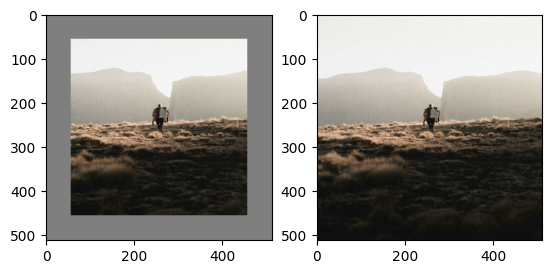

In [ ]:
# Testing Image Pipeline

for gen_image, real_image in train_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow(denormalize(gen_image[0]))
    plt.subplot(1,2,2)
    plt.imshow(denormalize(real_image[0]))
    plt.show()